# Title
Bank_Churn_Prediction_20200426_01_VinuPillai

## Overview
Businesses like banks which provide service have to worry about problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

## Purpose
Given a Bank customer, build a neural network based classifier that can determine whether they will leave or not in the next 6 months.

## Methodology
The dataset contains 10,000 sample points with 14 distinct features such as

* CustomerId
* Surname
* CreditScore
* Geography
* Gender
* Age
* Tenure
* Balance
* NumOfProducts - How many products the person has with bank
* HasCrCard - Is customer having a credit card through the bank?
* IsActiveMember - is customer an active user
* EstimatedSalary
* Exited - Did the customer leave the bank?

# Setup

## Library import
We import all the required Python libraries

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

# Data manipulation modules
import pandas as pd
import numpy as np
import datetime, os

# Collection and iteration utils
from collections import Counter
import itertools

# Scikit learn related modules
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, Adamax, SGD, Nadam, RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings('ignore')

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations Seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2
%load_ext tensorboard

# Generic Functions

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    #plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n\naccuracy={:0.4f}; miss-classification={:0.4f}'.format(accuracy, misclass))
    
def plot_heat_map(data):
    #get correlations of each features in dataset
    corrmat = data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(10, 6))
    #plot heat map
    g=sns.heatmap(data[top_corr_features].corr(),annot=True, cmap="RdYlGn")
    plt.show()

def print_class_weights(classes, y_variable):
    # computing the class weight ratio
    weighting = compute_class_weight('balanced', classes, y_variable)
    print(weighting)

def get_models():
    models, names, results = list(), list(), list()
    # Logistic
    models.append(Pipeline(steps=[('model', LogisticRegression())]))
    names.append('Logistic')
    # Logistic + Normalization
    models.append(Pipeline(steps=[('t1', MinMaxScaler()), ('model', LogisticRegression())]))
    names.append('Logistic with Min-Max')
    # Logistic + Power
    models.append(Pipeline(steps=[('t1', PowerTransformer()), ('model', LogisticRegression())]))
    names.append('Logistic with Power')
    # Logistic + Norm + Power
    models.append(Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()), ('model', LogisticRegression())]))
    names.append('Logistic with Min-Max + Power')
    return names, models

def evaluate_model(X, y, model):
    cv = KFold(n_splits=10, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores

def evaluate_models(data_X, data_y, confidence=0.997):
    mean_results, std_results = list(), list()
    names, models = get_models()
    for i in range(len(models)):
        scores = evaluate_model(data_X, data_y, models[i])
        mean_results.append(np.mean(scores))
        std_results.append(np.std(scores))
        value = str('%.1f%%' % (max(0.0, np.percentile(scores, ((1.0 - confidence)/2.0) * 100)) * 100)) + ' - ' + str('%.1f%%' % (min(1.0, np.percentile(scores, (confidence + ((1.0 - confidence)/2.0)) * 100)) * 100))
    return pd.DataFrame({'Model': names, 'Mean' : mean_results, 'Std' : std_results, 'Confidence' + ' [ '+ str('%.1f%%' % (confidence * 100)) + ' ]' : value}).sort_values(by='Mean', ascending=False)

# Data import
All the required data for the analysis is imported here.

In [3]:
bankDf = pd.read_csv('bank.csv')
bankDf.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
bankDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


There are no null values

In [5]:
bankDf.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


There is skewness in the balance column which can cause outliers

## Dropping columns not required for analysis
Dropping columns like RowNumber, CustomerId and Surname before processing

In [6]:
bankDf_dropped = bankDf.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1)
bankDf_dropped.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Unique values in dataset
A look at the different values in the dataset will give us an indication on the values existing for each of the columns

In [7]:
for column in bankDf_dropped.columns:
    print('---- ', column, ' ----')
    print(bankDf_dropped[column].unique())

----  CreditScore  ----
[619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771
 681 544 696 766 727 693 557 531 498 651 791 733 811 707 714 782 775 799
 602 744 588 747 583 627 731 629 438 642 806 474 559 429 680 749 734 644
 626 649 805 718 840 630 654 762 568 613 522 737 648 443 640 540 460 593
 801 611 802 745 483 690 49

Geography and Gender will need to be encoded before processing can start for models

Let's check if all values are existing in the data

In [8]:
bankDf_dropped.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## Plotting the dataset

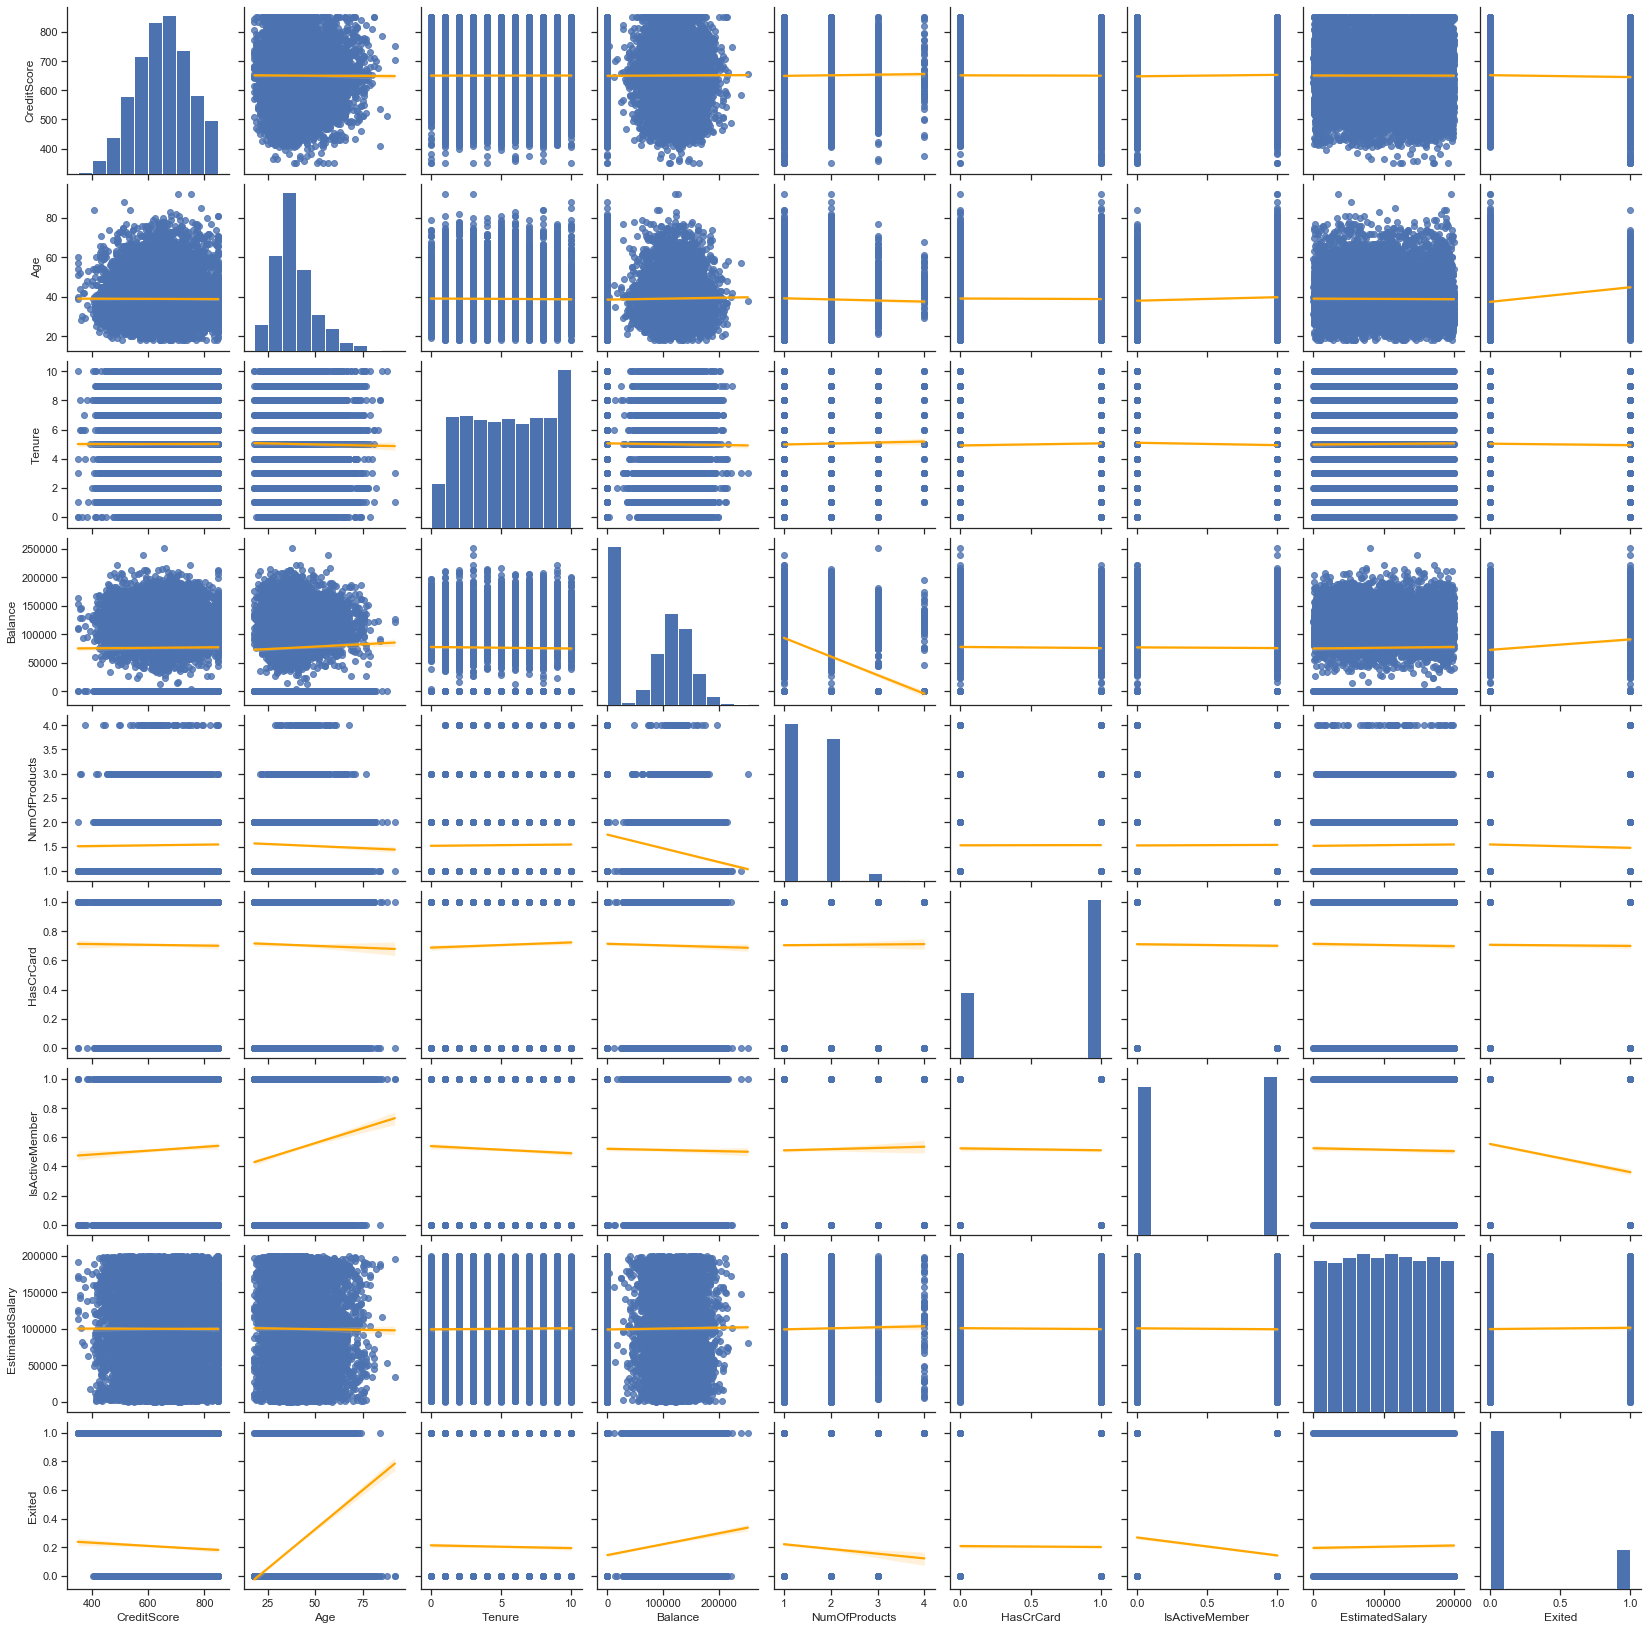

In [9]:
sns.pairplot(bankDf_dropped, kind='reg', plot_kws={'line_kws':{'color':'orange'}})

The features are indeed uncorrelated with each other and hence can be included in the modeling. Also the target column can be predicted using the available features

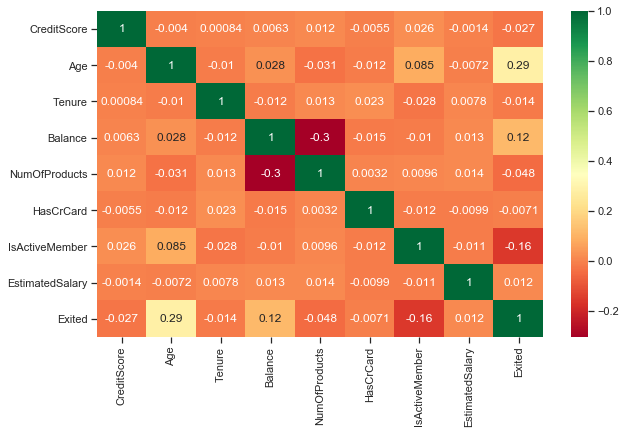

In [10]:
plot_heat_map(bankDf_dropped)

A look at the correlation data gives a clear picture on this conclusion

## Encoding the categorical columns

In [11]:
bankDf_encoded = pd.get_dummies(bankDf_dropped, columns=['Geography', 'Gender'])
bankDf_encoded.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [12]:
bankDf_X = bankDf_encoded.loc[:, bankDf_encoded.columns != 'Exited']
bankDf_y = bankDf_encoded[['Exited']]

## Plotting to check for Outliers

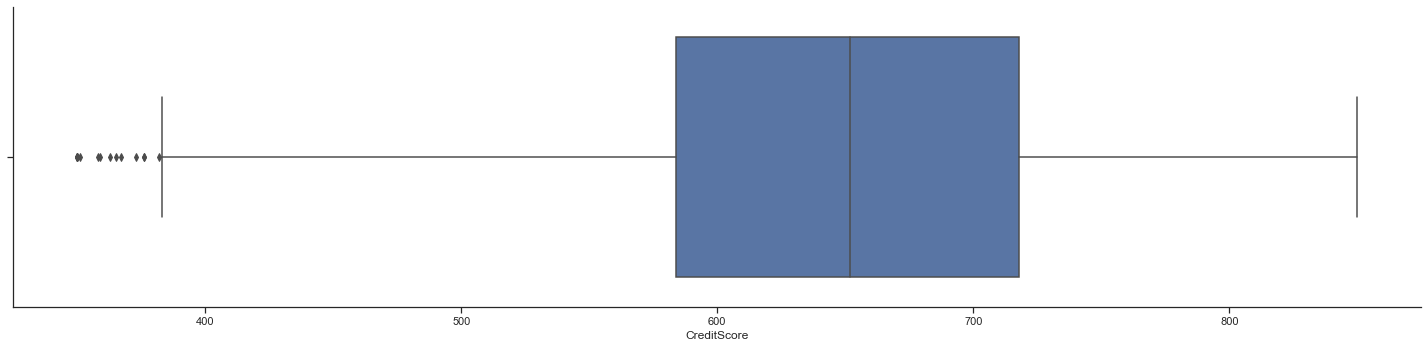

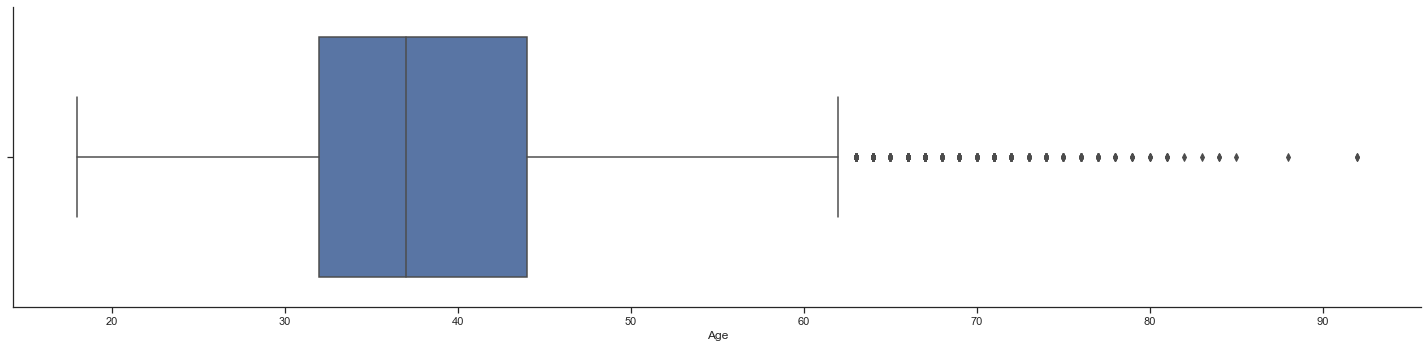

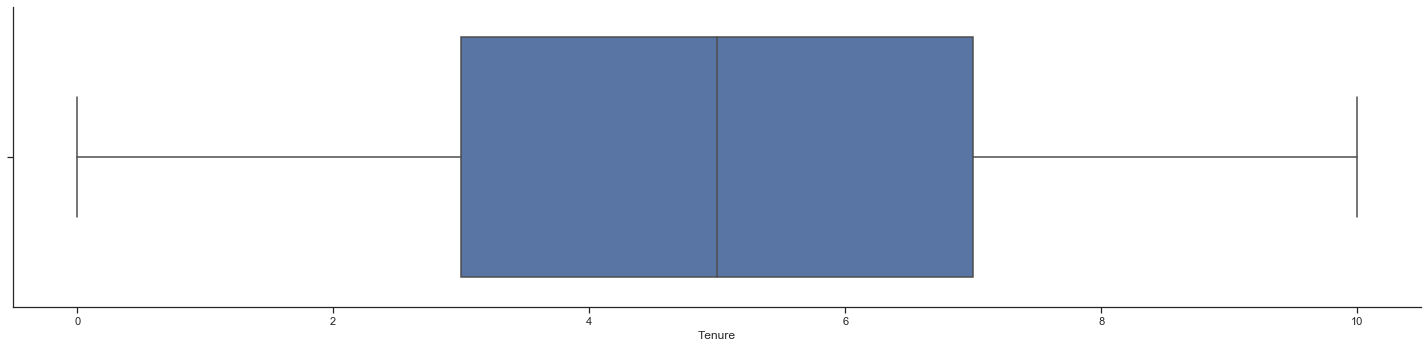

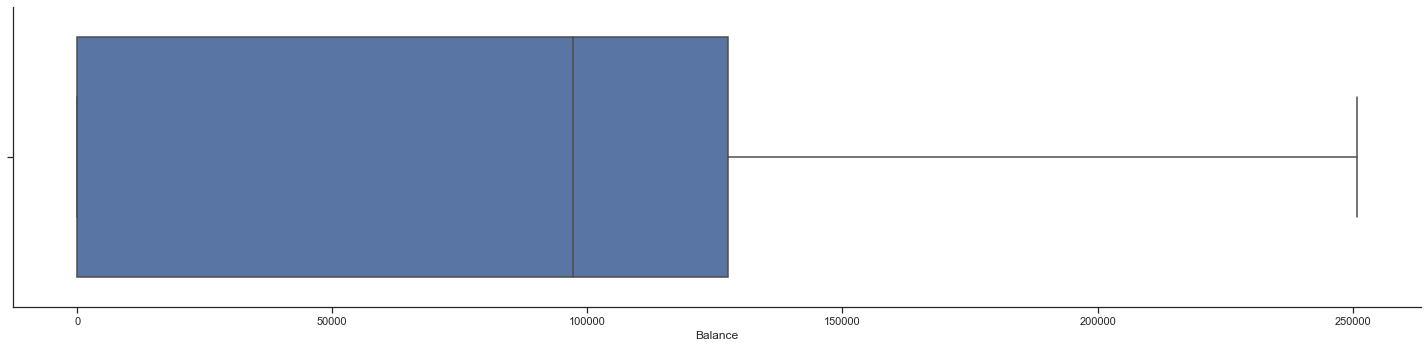

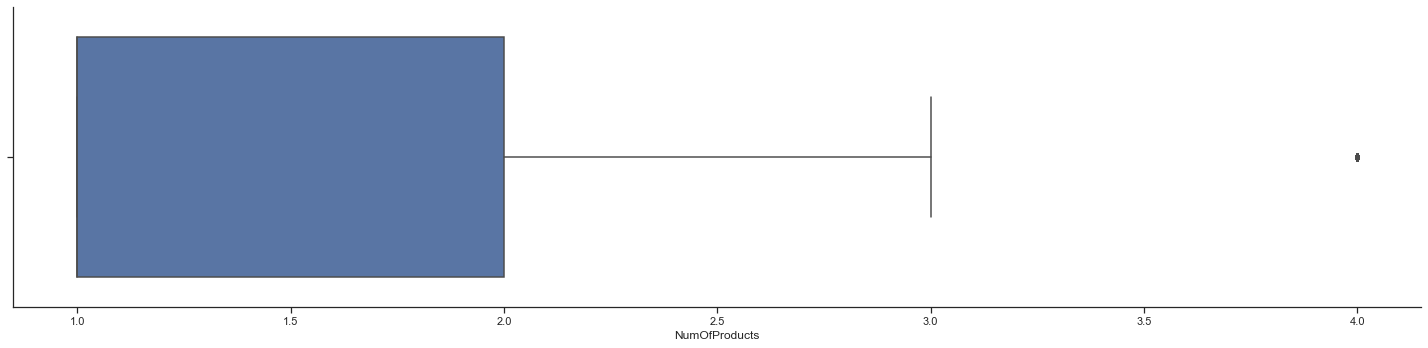

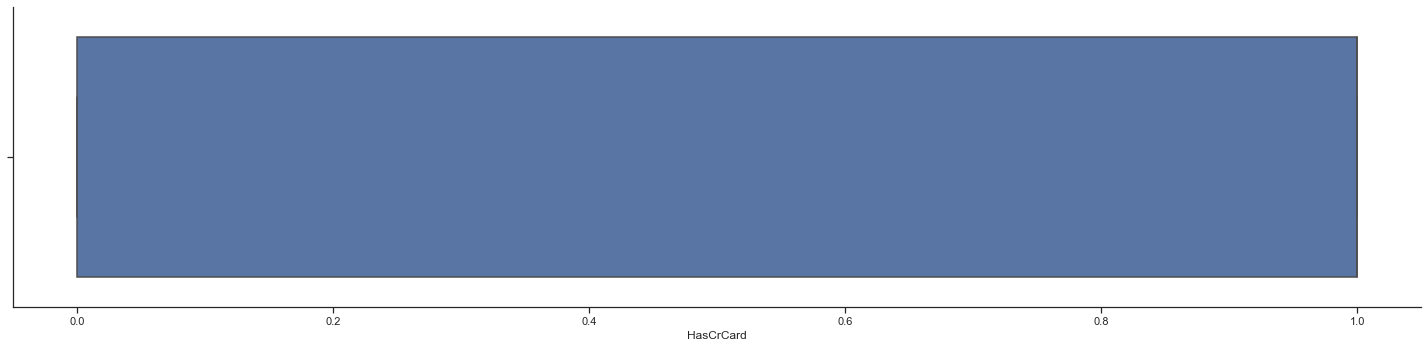

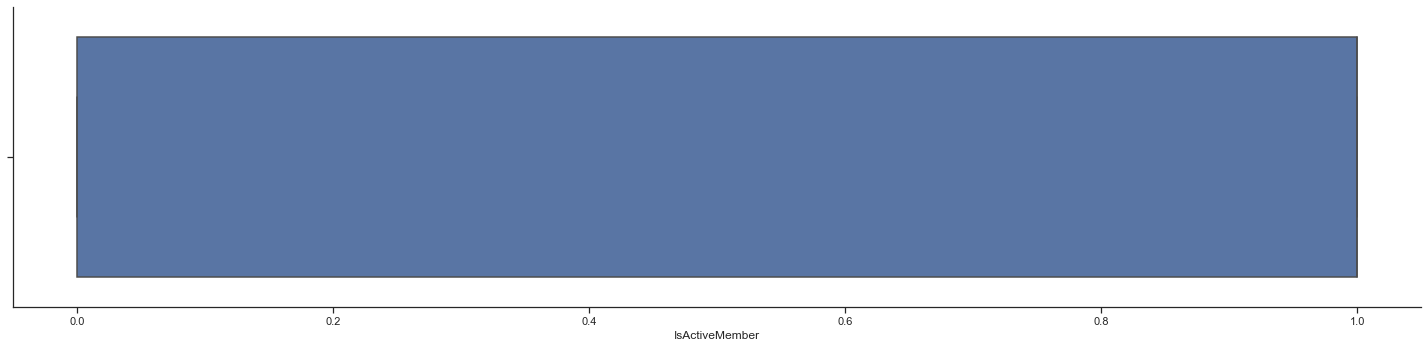

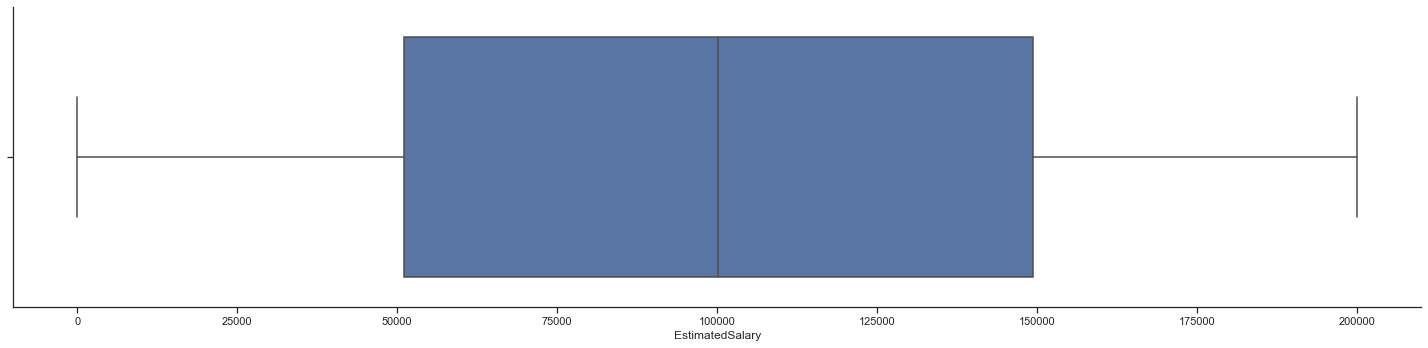

In [13]:
## Multivariate plotting for outliers
for feature in bankDf_X.select_dtypes(include=['int64', 'float64']).columns:
    sns.catplot(x=feature, kind='box', aspect=4, data=bankDf_X)
    plt.show()

We observe that 2 of the features have outliers that need treatment such as scaling /normalization

# Data processing
## Evaluate a baseline model

In [14]:
evaluate_models(bankDf_X, bankDf_y)

,Model,Mean,Std,Confidence [ 99.7% ]
3,Logistic with Min-Max + Power,0.778226,0.016089,75.5% - 80.2%
2,Logistic with Power,0.777426,0.015835,75.5% - 80.2%
1,Logistic with Min-Max,0.765226,0.019187,75.5% - 80.2%
0,Logistic,0.670117,0.020571,75.5% - 80.2%


This indicates that a baseline model can achieve 77% accuracy and the best possible scaling method is a combination of MinMax and Power transformation

## Scaling Data

In [15]:
scaler_pipeline = Pipeline(steps=[('scaler_1', MinMaxScaler()), ('scaler_2', PowerTransformer())])
preprocessor = ColumnTransformer(transformers=[('scaler', scaler_pipeline, 
                                                ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'])])
normalized_data = preprocessor.fit_transform(bankDf_X)
bankDf_X_normalized = bankDf_X.copy()
bankDf_X_normalized['CreditScore'] = pd.Series(normalized_data[:,0])
bankDf_X_normalized['Age'] = pd.Series(normalized_data[:,1])
bankDf_X_normalized['Tenure'] = pd.Series(normalized_data[:,2])
bankDf_X_normalized['Balance'] = pd.Series(normalized_data[:,3])
bankDf_X_normalized['NumOfProducts'] = pd.Series(normalized_data[:,4])
bankDf_X_normalized['EstimatedSalary'] = pd.Series(normalized_data[:,5])
bankDf_X_normalized.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.336225,0.460615,-1.042085,-1.220631,-0.967225,1,1,0.046056,1,0,0,1,0
1,-0.449283,0.367104,-1.412340,0.101907,-0.967225,0,1,0.238881,0,0,1,1,0
2,-1.523572,0.460615,1.029536,1.347960,1.850796,1,0,0.262686,1,0,0,1,0
3,0.494310,0.171097,-1.412340,-1.220631,0.933134,0,0,-0.084529,1,0,0,1,0
4,2.098683,0.551290,-1.042085,0.781779,-0.967225,1,1,-0.342918,0,0,1,1,0


In [16]:
bankDf_y.Exited.unique()

array([1, 0])

## Extract independent & target variable

In [17]:
X = bankDf_X_normalized
# Extracting the y or the target variable
y = bankDf_y.Exited
print('Class Weights')
print_class_weights([0, 1], y)

Class Weights
[0.62790406 2.45459008]


In [18]:
class_weights = {0: 0.62790406, 1: 2.45459008}

## Split the data into training and test set

In [19]:
# Splitting the data by 70:30 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# verify the data is randomized by looking at the ID field.
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7635,-1.383326,-1.026759,-1.042085,0.445462,-0.967225,1,0,0.994701,1,0,0,1,0
5284,0.978172,1.187148,-0.680118,0.351035,-0.967225,1,1,-1.249369,0,1,0,0,1
1457,2.098683,2.058407,-0.325635,-1.220631,0.933134,0,1,-0.604580,1,0,0,0,1
4785,-1.443495,-2.154928,-0.680118,1.300793,-0.967225,0,0,-0.965281,1,0,0,1,0
9158,-1.141710,-0.753611,1.675773,0.660971,-0.967225,1,1,1.005462,0,0,1,1,0


# Deep Neural Network
Defining the input and the output vectors that need to be input into the Deep learning network

In [20]:
feature_inputs_size = X_train.columns.size
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
#y_train = keras.utils.to_categorical(y_train, num_classes=2)
#y_test = keras.utils.to_categorical(y_test, num_classes=2)

## Define the Layers
Let us begin with defining the model. Attempt will be made to do cross validation for all parameter combinations to find the best hyperparameters namely
* Epochs
* Batch Size
* Optimizer
* Learning Rate
* Kernel Initializer
* Activation Function
* Dropout rate
* Number of neurons in hidden layer

We shall be using the KerasClassifier for this purpose and evaluate it using GridSearchCV to find the best hyperparameter possible for each of the above parameters

We will define a network of 2 hidden layers and an output layer with a sigmoid activation function since this is binary classification.

In [22]:
def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(feature_inputs_size, activation = 'relu'))
    model.add(Dense(10, activation='relu'))
    #the output layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

## Finding best Batch Size and Epoch

In [23]:
batch_epochs_model = KerasClassifier(build_fn=create_model, verbose=0)
batch_epocs_param_grid = {
    'batch_size' : [50, 100, 200, 500],
    'epochs' : [100, 200, 500, 1000]
}
grid_batch_epochs = GridSearchCV(estimator=batch_epochs_model, param_grid=batch_epocs_param_grid, n_jobs=-1, cv=5)
grid_batch_epochs_fit = grid_batch_epochs.fit(X_train, y_train)
print('Best Score %f with %s' % (grid_batch_epochs.best_score_, grid_batch_epochs.best_params_))

Best Score 0.859857 with {'batch_size': 50, 'epochs': 100}


In [24]:
selected_epochs = grid_batch_epochs.best_params_['epochs']
selected_batch_size = grid_batch_epochs.best_params_['batch_size']

## Finding best Optimizer

Using the best epochs and batch_size from the previous iteration

In [25]:
batch_optimizers_model = KerasClassifier(build_fn=create_model, verbose=0, epochs=selected_epochs, batch_size=selected_batch_size)
optimizers_param_grid = {
    'optimizer' : ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
}
grid_optimizers = GridSearchCV(estimator=batch_optimizers_model, param_grid=optimizers_param_grid, n_jobs=-1, cv=5)
grid_optimizers_fit = grid_optimizers.fit(X_train, y_train)
print('Best Score %f with %s' % (grid_optimizers_fit.best_score_, grid_optimizers_fit.best_params_))

Best Score 0.861000 with {'optimizer': 'RMSprop'}


## Finding best Learning Rate
Using the best Optimizer, epochs and batch_size from the previous iteration

In [27]:
def create_model_learning_rate(learning_rate=0.01):
    model = Sequential()
    model.add(Dense(feature_inputs_size, activation = 'relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='relu'))
    #the output layer
    model.add(Dense(1, activation='sigmoid'))
    optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

learning_rate_model = KerasClassifier(build_fn=create_model_learning_rate, verbose=0, epochs=selected_epochs, batch_size=selected_batch_size)
learning_rate_param_grid = {
    'learning_rate' : [0.001, 0.005, 0.01, 0.1, 0.2]
}
grid_learning_rate = GridSearchCV(estimator=learning_rate_model, param_grid=learning_rate_param_grid, n_jobs=-1, cv=5)
grid_learning_rate_fit = grid_learning_rate.fit(X_train, y_train)
print('Best Score %f with %s' % (grid_learning_rate_fit.best_score_, grid_learning_rate_fit.best_params_))

Best Score 0.855143 with {'learning_rate': 0.005}


In [28]:
selected_learning_rate = grid_learning_rate_fit.best_params_['learning_rate']

## Finding the best Kernel Initializer
Using the best learning rate, Optimizer, epochs and batch_size from the previous iteration

In [31]:
def create_model_kernel_init(kernel_initializer='he_uniform'):
    model = Sequential()
    model.add(Dense(feature_inputs_size, activation = 'relu', kernel_initializer=kernel_initializer))
    model.add(Dense(10, activation='relu', kernel_initializer=kernel_initializer))
    #the output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))
    optimizer = RMSprop(learning_rate=selected_learning_rate)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

kernel_init_model = KerasClassifier(build_fn=create_model_kernel_init, verbose=0, epochs=selected_epochs, batch_size=selected_batch_size)
kernel_init_param_grid = {
    'kernel_initializer' : ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_uniform', 'he_normal']
}
grid_kernel_init = GridSearchCV(estimator=kernel_init_model, param_grid=kernel_init_param_grid, n_jobs=-1, cv=5)
grid_kernel_init_fit = grid_kernel_init.fit(X_train, y_train)
print('Best Score %f with %s' % (grid_kernel_init_fit.best_score_, grid_kernel_init_fit.best_params_))

Best Score 0.861857 with {'kernel_initializer': 'he_normal'}


In [32]:
kernel_initializer = grid_kernel_init_fit.best_params_['kernel_initializer']

## Finding the best Activation Function
Using the best Kernel initializer, learning rate, Optimizer, epochs and batch_size from the previous iteration

In [33]:
def create_model_activation(activation='relu'):
    model = Sequential()
    model.add(Dense(feature_inputs_size, activation=activation, kernel_initializer=kernel_initializer))
    model.add(Dense(10, activation=activation, kernel_initializer=kernel_initializer))
    #the output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))
    optimizer = RMSprop(learning_rate=selected_learning_rate)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

activation_model = KerasClassifier(build_fn=create_model_activation, verbose=0, epochs=selected_epochs, batch_size=selected_batch_size)
activation_param_grid = {
    'activation' : ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
}
grid_activation = GridSearchCV(estimator=activation_model, param_grid=activation_param_grid, n_jobs=-1, cv=5)
grid_activation_fit = grid_activation.fit(X_train, y_train)
print('Best Score %f with %s' % (grid_activation_fit.best_score_, grid_activation_fit.best_params_))

Best Score 0.858000 with {'activation': 'sigmoid'}


In [35]:
selected_activation = grid_activation_fit.best_params_['activation']

## Finding the best Dropout rate
Using the best Activation Function, Kernel initializer, learning rate, Optimizer, epochs and batch_size from the previous iteration

In [36]:
def create_model_dropout(rate=0.0):
    model = Sequential()
    model.add(Dense(feature_inputs_size, activation=selected_activation, kernel_initializer=kernel_initializer))
    model.add(Dropout(rate=rate))
    model.add(Dense(10, activation=selected_activation, kernel_initializer=kernel_initializer))
    model.add(Dropout(rate=rate))
    #the output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))
    optimizer = RMSprop(learning_rate=selected_learning_rate)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

dropout_model = KerasClassifier(build_fn=create_model_dropout, verbose=0, epochs=selected_epochs, batch_size=selected_batch_size)
dropout_param_grid = {
    'rate' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
grid_dropout = GridSearchCV(estimator=dropout_model, param_grid=dropout_param_grid, n_jobs=-1, cv=5)
grid_dropout_fit = grid_dropout.fit(X_train, y_train)
print('Best Score %f with %s' % (grid_dropout_fit.best_score_, grid_dropout_fit.best_params_))

Best Score 0.857714 with {'rate': 0.0}


In [37]:
selected_rate = grid_dropout_fit.best_params_['rate']

## Finding the best number of neurons in the hidden layer
Using the best dropout rate, Activation Function, Kernel initializer, learning rate, Optimizer, epochs and batch_size from the previous iteration

In [38]:
def create_model_units(units=10):
    model = Sequential()
    model.add(Dense(feature_inputs_size, activation=selected_activation, kernel_initializer=kernel_initializer))
    model.add(Dropout(rate=selected_rate))
    model.add(Dense(units, activation=selected_activation, kernel_initializer=kernel_initializer))
    model.add(Dropout(rate=selected_rate))
    #the output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))
    optimizer = RMSprop(learning_rate=selected_learning_rate)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

units_model = KerasClassifier(build_fn=create_model_units, verbose=0, epochs=selected_epochs, batch_size=selected_batch_size)
units_param_grid = {
    'units' : [5, 10, 15, 20, 25, 30]
}
grid_units = GridSearchCV(estimator=units_model, param_grid=units_param_grid, n_jobs=-1, cv=5)
grid_units_fit = grid_units.fit(X_train, y_train)
print('Best Score %f with %s' % (grid_units_fit.best_score_, grid_units_fit.best_params_))

Best Score 0.859429 with {'units': 20}


In [39]:
selected_units = grid_units_fit.best_params_['units']

## Building the final Network using best parameters

Let us now pick all the best combination of the hyperparameters from the above analysis to build the final network

### Model 1

Train Accuracy: 0.870, Test Accuracy: 0.861


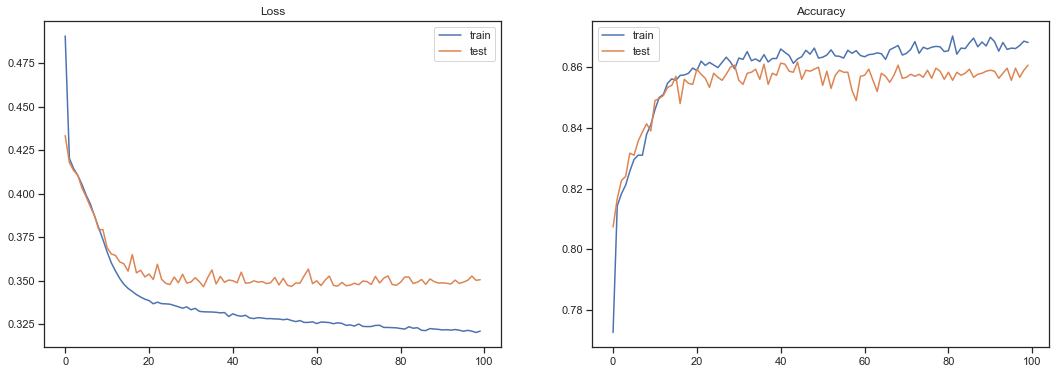

In [78]:
model1 = Sequential()
model1.add(Dense(feature_inputs_size, activation=selected_activation, kernel_initializer=kernel_initializer))
model1.add(Dropout(rate=selected_rate))
model1.add(Dense(selected_units, activation=selected_activation, kernel_initializer=kernel_initializer))
model1.add(Dropout(rate=selected_rate))
#the output layer
model1.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))
optimizer = RMSprop(learning_rate=selected_learning_rate)
model1.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model1.fit(X_train, y_train, validation_data=[X_test, y_test], epochs=selected_epochs, batch_size=selected_batch_size, verbose=0)
_, train_accuracy = model1.evaluate(X_train, y_train, verbose=0)
_, test_accuracy = model1.evaluate(X_test, y_test, verbose=0)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_accuracy, test_accuracy))
# plot loss during training/validation
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training/validation
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

From the above plot it is seen that the validation loss tends to diverge from the training loss which indicates the sign of overfitting. This can be reduced by adding Dropout layer in the network. Increasing the value of the dropout rate from 0.0 to 0.2 shows that the validation loss tends to stabilize  near the training loss and accuracy also tends to become nearer to the accuracy of training.

### Model 2

Train Accuracy: 0.867, Test Accuracy: 0.862


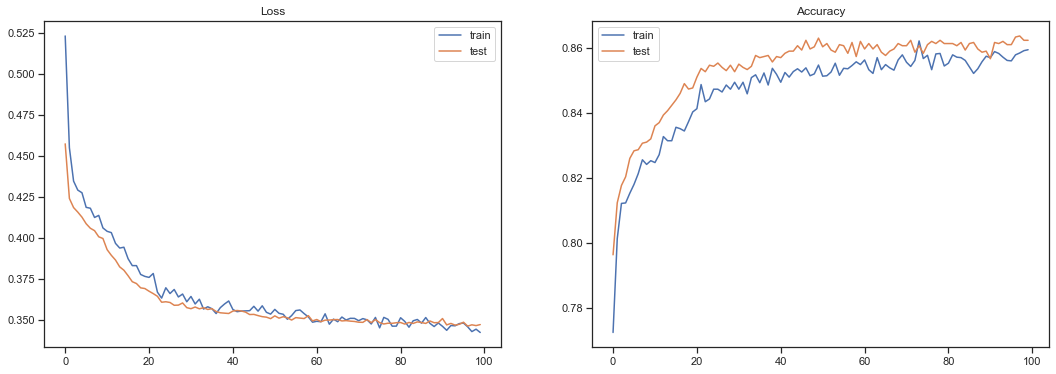

In [79]:
model2 = Sequential()
model2.add(Dense(feature_inputs_size, activation=selected_activation, kernel_initializer=kernel_initializer))
model2.add(Dropout(rate=0.2))
model2.add(Dense(selected_units, activation=selected_activation, kernel_initializer=kernel_initializer))
model2.add(Dropout(rate=0.2))
#the output layer
model2.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))
optimizer = RMSprop(learning_rate=selected_learning_rate)
model2.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model2.fit(X_train, y_train, validation_data=[X_test, y_test], epochs=selected_epochs, batch_size=selected_batch_size, verbose=0)
_, train_accuracy = model2.evaluate(X_train, y_train, verbose=0)
_, test_accuracy = model2.evaluate(X_test, y_test, verbose=0)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_accuracy, test_accuracy))
# plot loss during training/validation
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training/validation
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

### Model 3

Reducing the dropout rate even further shows that the accuracy doesn't improve any further but the training loss is increasing. Reducing the learning rate even further makes the accuracy fluctuate drastically.

This means we can choose the model from section 'Model 2' above for our predictions as it is having higher accuracy

Train Accuracy: 0.841, Test Accuracy: 0.839


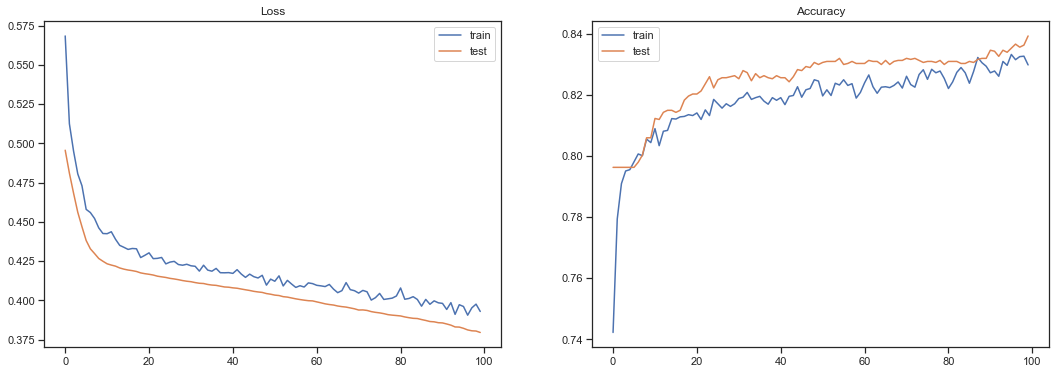

In [80]:
model3 = Sequential()
model3.add(Dense(feature_inputs_size, activation=selected_activation, kernel_initializer=kernel_initializer))
model3.add(Dropout(rate=0.2))
model3.add(Dense(selected_units*0.25, activation=selected_activation, kernel_initializer=kernel_initializer))
model3.add(Dropout(rate=0.2))
#the output layer
model3.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))
optimizer = RMSprop(learning_rate=selected_learning_rate*0.25)
model3.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model3.fit(X_train, y_train, validation_data=[X_test, y_test], epochs=selected_epochs, batch_size=selected_batch_size, verbose=0)
_, train_accuracy = model3.evaluate(X_train, y_train, verbose=0)
_, test_accuracy = model3.evaluate(X_test, y_test, verbose=0)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_accuracy, test_accuracy))
# plot loss during training/validation
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training/validation
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## Applying Threshold, Accuracy and Confusion Matrix

Model Score Summary
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2389
           1       0.79      0.44      0.57       611

    accuracy                           0.86      3000
   macro avg       0.83      0.71      0.74      3000
weighted avg       0.85      0.86      0.85      3000



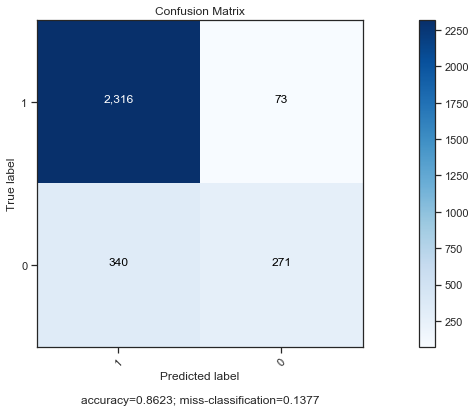

In [83]:
threshold = 0.5
y_predictions = [1 if line > threshold else 0 for line in model2.predict(X_test)]
print('Model Score Summary')
print('------------------------------------------------------')
print(metrics.classification_report(y_test, y_predictions))

fig, ax = plt.subplots(figsize=(20, 6))
plot_confusion_matrix(cm           = metrics.confusion_matrix(y_test, y_predictions), 
                      normalize    = False,
                      target_names = ['1', '0'],
                      title        = "Confusion Matrix")
plt.show()